In [1]:
import pandas as pd
import numpy as np

## Ingest data from remote MySQL database

In [1]:
from sqlalchemy import create_engine


In [46]:
ENDPOINT = 'heicoders-playground.c2ced10ceyki.ap-southeast-1.rds.amazonaws.com'
PORT = 3306
USERNAME = 'student300'
PASSWORD = 'heicoders_AI300'
DBNAME = 'ai300_capstone'

database_conn = create_engine(f'mysql+pymysql://{USERNAME}:{PASSWORD}@{ENDPOINT}/{DBNAME}')

In [10]:

def get_columns(dbconn, schema, table):
    query = f"""
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = '{schema}' and table_name = '{table}';
    """

    df = pd.read_sql(query, dbconn)

    return df['COLUMN_NAME'].to_list()

    

In [13]:
acct_cols = get_columns(database_conn, DBNAME, 'account')
acct_cols

['account_id',
 'contract_type',
 'customer_id',
 'has_device_protection',
 'has_internet_service',
 'has_multiple_lines',
 'has_online_backup',
 'has_online_security',
 'has_phone_service',
 'has_premium_tech_support',
 'has_unlimited_data',
 'internet_type',
 'num_referrals',
 'paperless_billing',
 'payment_method',
 'tenure_months']

In [14]:
acct_usg_cols = get_columns(database_conn, DBNAME, 'account_usage')
acct_usg_cols

['account_id',
 'avg_gb_download_monthly',
 'avg_long_distance_fee_monthly',
 'stream_movie',
 'stream_music',
 'stream_tv',
 'total_charges_quarter',
 'total_long_distance_fee',
 'total_monthly_fee',
 'total_refunds']

In [17]:
churn_cols = get_columns(database_conn, DBNAME, 'churn_status')
churn_cols

['churn_category', 'churn_label', 'churn_reason', 'customer_id', 'status']

In [18]:
city_cols = get_columns(database_conn, DBNAME, 'city')
city_cols

['area_id', 'city', 'latitutde', 'longitude', 'population', 'zip_code']

In [19]:
cust_cols = get_columns(database_conn, DBNAME, 'customer')
cust_cols

['age',
 'customer_id',
 'gender',
 'married',
 'num_dependents',
 'senior_citizen',
 'zip_code']

In [47]:
def load_data_from_db(dbconn, verbose=False):

    join_acct_usg_cols = ['account_id']
    join_cust_cols = ['customer_id']
    join_city_cols = ['zip_code']

    acct_tbl_alias = 'a'
    acct_usg_tbl_alias = 'au'
    cust_tbl_alias = 'cu'
    city_tbl_alias = 'ct'
    churn_tbl_alias = 'ch'
    
    sel_acct_cols = [f'{acct_tbl_alias}.{c}' for c in acct_cols]
    sel_acct_usg_cols = [f'{acct_usg_tbl_alias}.{c}' for c in acct_usg_cols if c not in join_acct_usg_cols]
    sel_cust_cols = [f'{cust_tbl_alias}.{c}' for c in cust_cols if c not in join_cust_cols]
    sel_city_cols = [f'{city_tbl_alias}.{c}' for c in city_cols if c not in join_city_cols]
    #sel_churn_cols = [f'{churn_tbl_alias}.{c}' for c in ['churn_label']]
    
    query = f"""
        SELECT {','.join(sel_acct_cols + sel_acct_usg_cols + sel_cust_cols + sel_city_cols)},
            CASE
        		WHEN {churn_tbl_alias}.status = 'Churned' then 1
                ELSE 0
            END AS status
        FROM ai300_capstone.account {acct_tbl_alias}
        LEFT JOIN ai300_capstone.account_usage {acct_usg_tbl_alias} on {acct_tbl_alias}.account_id = {acct_usg_tbl_alias}.account_id
        LEFT JOIN ai300_capstone.customer {cust_tbl_alias} on {acct_tbl_alias}.customer_id = {cust_tbl_alias}.customer_id
        LEFT JOIN ai300_capstone.city {city_tbl_alias} on {cust_tbl_alias}.zip_code = {city_tbl_alias}.zip_code
        INNER JOIN ai300_capstone.churn_status {churn_tbl_alias} on {acct_tbl_alias}.customer_id = {churn_tbl_alias}.customer_id;
    """
    if verbose:
        print(query)

    df = pd.read_sql(query, dbconn)

    return(df)


In [48]:
churn_df = load_data_from_db(database_conn)

### Save to local

### Load from local csv

In [2]:
churn_df = pd.read_csv('../data/churn.csv')

In [3]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_id                     7043 non-null   object 
 1   contract_type                  7043 non-null   object 
 2   customer_id                    7043 non-null   object 
 3   has_device_protection          7043 non-null   object 
 4   has_internet_service           7043 non-null   object 
 5   has_multiple_lines             7043 non-null   object 
 6   has_online_backup              7043 non-null   object 
 7   has_online_security            7043 non-null   object 
 8   has_phone_service              7043 non-null   object 
 9   has_premium_tech_support       7043 non-null   object 
 10  has_unlimited_data             7043 non-null   object 
 11  internet_type                  5517 non-null   object 
 12  num_referrals                  7043 non-null   i

In [4]:
churn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
tenure_months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
avg_gb_download_monthly,7043.0,20.515405,20.418940,0.000000,3.000000,17.000000,27.000000,85.000000
avg_long_distance_fee_monthly,7043.0,22.958954,15.448113,0.000000,9.210000,22.890000,36.395000,49.990000
total_charges_quarter,7043.0,2280.381264,2266.220462,18.800000,400.150000,1394.550000,3786.600000,8684.800000
total_long_distance_fee,7043.0,749.099262,846.660055,0.000000,70.545000,401.440000,1191.100000,3564.720000
total_monthly_fee,7043.0,64.761692,30.090047,18.250000,35.500000,70.350000,89.850000,118.750000
total_refunds,7043.0,1.962182,7.902614,0.000000,0.000000,0.000000,0.000000,49.790000
age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
num_dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000


### Data cleaning

In [5]:
churn_df['internet_type'] = churn_df['internet_type'].fillna('Missing')

In [6]:
print(churn_df['internet_type'].nunique())
churn_df['internet_type'].value_counts()

4


internet_type
Fiber Optic    3035
DSL            1652
Missing        1526
Cable           830
Name: count, dtype: int64

### Feature Engineering

In [7]:
churn_df['num_referrals'].value_counts()

num_referrals
0     3821
1     1086
5      264
3      255
7      248
9      238
4      236
2      236
10     223
6      221
8      213
11       2
Name: count, dtype: int64

In [8]:
(churn_df.groupby(['num_referrals'])
    .agg(count = ('account_id', 'count'),
         churn_rate = ('status', 'mean'))
    .reset_index()
    .sort_values(by=['churn_rate'], ascending=False)
)

,num_referrals,count,churn_rate
1,1,1086,0.466851
0,0,3821,0.325831
3,3,255,0.125490
2,2,236,0.110169
5,5,264,0.079545
4,4,236,0.076271
6,6,221,0.036199
7,7,248,0.024194
9,9,238,0.016807
8,8,213,0.009390


In [9]:
churn_df['referrals_category'] = np.where(churn_df['num_referrals'] <= 1, '0-1',
                                 np.where(churn_df['num_referrals'] <= 3, '2-3',
                                 np.where(churn_df['num_referrals'] <= 5, '4-5',
                                 '6+'
)))

churn_df['referrals_category'].value_counts()

referrals_category
0-1    4907
6+     1145
4-5     500
2-3     491
Name: count, dtype: int64

In [10]:
(churn_df.groupby(['num_dependents'])
    .agg(count = ('account_id', 'count'),
         churn_rate = ('status', 'mean'))
    .reset_index()
    .sort_values(by=['churn_rate'], ascending=False)
)

,num_dependents,count,churn_rate
7,7,2,0.500000
6,6,3,0.333333
0,0,5416,0.325517
5,5,10,0.200000
4,4,9,0.111111
1,1,553,0.068716
2,2,531,0.062147
3,3,517,0.058027
8,8,1,0.000000
9,9,1,0.000000


In [11]:

churn_df['has_dependents'] = np.where(churn_df['num_dependents'] == 0, 'No', 'Yes')


In [12]:
churn_df['has_dependents'].value_counts()

has_dependents
No     5416
Yes    1627
Name: count, dtype: int64

In [13]:

X = churn_df.drop(columns=['status'])
X

,account_id,contract_type,customer_id,has_device_protection,has_internet_service,has_multiple_lines,has_online_backup,has_online_security,has_phone_service,has_premium_tech_support,...,num_dependents,senior_citizen,zip_code,area_id,city,latitutde,longitude,population,referrals_category,has_dependents
0,AAJU-HMJLK,One Year,0334-ZFJSR,No,Yes,Yes,Yes,Yes,Yes,Yes,...,0,No,92123,371,San Diego,32.808814,-117.134694,25232,0-1,No
1,AAMB-TJYWC,Two Year,4006-HKYHO,Yes,Yes,No,Yes,Yes,Yes,Yes,...,0,No,93311,696,Bakersfield,35.162070,-119.194488,20440,0-1,No
2,AANL-MWPZF,Two Year,3258-SYSWS,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,0,Yes,92040,329,Lakeside,32.909873,-116.906774,42277,0-1,No
3,ABBQ-EXMMW,Two Year,1820-DJFPH,No,No,Yes,No,No,Yes,No,...,3,No,95555,1310,Orick,41.336354,-124.044354,494,4-5,Yes
4,ABHW-EXJZF,Two Year,0582-AVCLN,No,No,No,No,No,Yes,No,...,0,No,93304,690,Bakersfield,35.339796,-119.023552,44588,0-1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,ZWXF-QGPFD,One Year,6848-YLDFR,No,Yes,No,Yes,No,Yes,Yes,...,2,No,96035,1546,Gerber,40.031940,-122.176023,3357,6+,Yes
7039,ZXNR-BOLMC,Month-to-Month,7587-AOVVU,No,Yes,Yes,Yes,Yes,Yes,Yes,...,1,No,95521,1289,Arcata,40.839958,-124.003757,19596,0-1,Yes
7040,ZXYG-EZZNH,Month-to-Month,7479-NITWS,Yes,Yes,Yes,No,No,Yes,No,...,0,No,92341,451,Green Valley Lake,34.244411,-117.072654,317,0-1,No
7041,ZYQO-YPQDV,Two Year,8910-LEDAG,No,Yes,No,No,No,Yes,No,...,0,Yes,93651,805,Prather,37.007238,-119.505661,1314,2-3,No


In [14]:
y = churn_df['status']
y

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    1
7041    0
7042    0
Name: status, Length: 7043, dtype: int64

### Models

In [15]:
from sklearn.model_selection import StratifiedKFold

k = 10
skf = StratifiedKFold(n_splits=k, random_state=5, shuffle=True)

In [16]:
cols_to_drop = ['account_id', 'customer_id', 'status']

#cb_features = [c for c in X.columns if c not in cols_to_drop]

cb_features = [
    'contract_type',
    #'num_referrals',
    'referrals_category',
    #'num_dependents',
    'has_dependents',
    'internet_type',
    'payment_method',
    'tenure_months',
    'total_monthly_fee',
    'total_charges_quarter',
    'married',
    'senior_citizen',
    'city'
]

cb_features

['contract_type',
 'referrals_category',
 'has_dependents',
 'internet_type',
 'payment_method',
 'tenure_months',
 'total_monthly_fee',
 'total_charges_quarter',
 'married',
 'senior_citizen',
 'city']

In [17]:
cb_cate_cols = X[cb_features].select_dtypes(exclude='number').columns.to_list()
cb_cate_cols

['contract_type',
 'referrals_category',
 'has_dependents',
 'internet_type',
 'payment_method',
 'married',
 'senior_citizen',
 'city']

In [18]:
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score


In [ ]:
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

In [72]:
cb_clf = CatBoostClassifier(learning_rate=0.1,
                            random_state=5,
                            depth=6,
                            )

cb_skf_auc_scores = [] 

# Iterate through each fold and calculate the RMSE for each fold
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    # Extract the training and test data
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model
    print(f'Fold {i}:')
    cb_fit = cb_clf.fit(X_train_kf[cb_features], y_train_kf,
                        eval_set=(X_test_kf[cb_features], y_test_kf),
                        cat_features=cb_cate_cols,
                        early_stopping_rounds=25,
                        verbose=100)
    y_pred_kf = cb_clf.predict_proba(X_test_kf[cb_features])[:, 1]
    
    auc_kf = roc_auc_score(y_test_kf, y_pred_kf)
    cb_skf_auc_scores.append(auc_kf)

    print('=========\n')

Fold 0:
0:	learn: 0.6190697	test: 0.6169695	best: 0.6169695 (0)	total: 29.9ms	remaining: 29.9s
100:	learn: 0.2936713	test: 0.3016207	best: 0.3015049 (98)	total: 4.01s	remaining: 35.7s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.3015049497
bestIteration = 98

Shrink model to first 99 iterations.

Fold 1:
0:	learn: 0.6147059	test: 0.6117546	best: 0.6117546 (0)	total: 30.1ms	remaining: 30s
100:	learn: 0.2933954	test: 0.3034269	best: 0.3032960 (98)	total: 4.09s	remaining: 36.4s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.3013215083
bestIteration = 123

Shrink model to first 124 iterations.

Fold 2:
0:	learn: 0.6154532	test: 0.6130128	best: 0.6130128 (0)	total: 30.9ms	remaining: 30.8s
100:	learn: 0.2924695	test: 0.3104624	best: 0.3104624 (100)	total: 3.88s	remaining: 34.6s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.3085803273
bestIteration = 131

Shrink model to first 132 iterations.

Fold 3:
0:	learn: 0.6274048	test: 

In [28]:
# 0.1, 6
# all features
print(cb_skf_auc_scores)
print(np.mean(cb_skf_auc_scores))

[0.9247223579221625, 0.9084579058785214, 0.9124967878650195]
0.9152256838885678


In [37]:
# 0.1, 6
# ['contract_type', 'num_dependents', 'internet_type', 'payment_method', 'tenure_months', 'total_monthly_fee', 'total_charges_quarter', 'married', 'senior_citizen', 'city']
print(cb_skf_auc_scores)
print(np.mean(cb_skf_auc_scores))

[0.9031851489985344, 0.8864121711215018, 0.8860502098594855]
0.8918825099931739


In [42]:
# 0.1, 6
# ['contract_type', 'num_referrals', 'num_dependents', 'internet_type', 'payment_method', 'tenure_months', 'total_monthly_fee', 'total_charges_quarter', 'married', 'senior_citizen', 'city']
print(cb_skf_auc_scores)
print(np.mean(cb_skf_auc_scores))

[0.9244529741549771, 0.9046265149929047, 0.9073629582180378]
0.9121474824553065


In [73]:
# 0.1, 6
# ['contract_type', 'referrals_category', 'has_dependents', 'internet_type', 'payment_method', 'tenure_months', 'total_monthly_fee', 'total_charges_quarter', 'married', 'senior_citizen', 'city']
print(cb_skf_auc_scores)
print(np.mean(cb_skf_auc_scores))

[0.9248652778064543, 0.9261041025746908, 0.9223153634918341, 0.9287271142109853, 0.9087547450842478, 0.9070015204956609, 0.9065981236876675, 0.9021193847681502, 0.9107355268465747, 0.9097373783344884]
0.9146958537300754


In [43]:
print(cb_features)

['contract_type', 'referrals_category', 'has_dependents', 'internet_type', 'payment_method', 'tenure_months', 'total_monthly_fee', 'total_charges_quarter', 'married', 'senior_citizen', 'city']


In [ ]:
cb_hp_space = [
    Integer(2, 10, name='depth'),
    Real(1e-3, 0.1, name='learning_rate')
]

In [19]:
cb_clf = CatBoostClassifier(learning_rate=0.1,
                            random_state=5,
                            depth=6,
                            iterations = 130,
                            )

In [20]:
cb_clf.fit(X[cb_features], y,
            cat_features=cb_cate_cols,
            verbose=10)

0:	learn: 0.6474761	total: 222ms	remaining: 28.6s
10:	learn: 0.4401378	total: 933ms	remaining: 10.1s
20:	learn: 0.3788495	total: 1.66s	remaining: 8.62s
30:	learn: 0.3512437	total: 2.35s	remaining: 7.52s
40:	learn: 0.3365714	total: 3.05s	remaining: 6.62s
50:	learn: 0.3282501	total: 3.82s	remaining: 5.91s
60:	learn: 0.3224290	total: 4.58s	remaining: 5.18s
70:	learn: 0.3176021	total: 5.35s	remaining: 4.45s
80:	learn: 0.3144521	total: 6.2s	remaining: 3.75s
90:	learn: 0.3113479	total: 7s	remaining: 3s
100:	learn: 0.3096041	total: 7.78s	remaining: 2.23s
110:	learn: 0.3070978	total: 8.6s	remaining: 1.47s
120:	learn: 0.3050636	total: 9.39s	remaining: 699ms
129:	learn: 0.3042053	total: 10.1s	remaining: 0us


In [21]:
y_pred_cb = cb_clf.predict_proba(X[cb_features])[:,1]

auc_cb = roc_auc_score(y, y_pred_cb)

print(auc_cb)

0.928001585488458


In [17]:
from pathlib import Path

Path("../model").mkdir(exist_ok=True)

In [22]:
import joblib

joblib.dump(cb_clf, '../model/catboost_model_small.pkl')

['../model/catboost_model_small.pkl']

In [21]:
X.iloc[0]

account_id                        AAJU-HMJLK
contract_type                       One Year
customer_id                       0334-ZFJSR
has_device_protection                     No
has_internet_service                     Yes
has_multiple_lines                       Yes
has_online_backup                        Yes
has_online_security                      Yes
has_phone_service                        Yes
has_premium_tech_support                 Yes
has_unlimited_data                        No
internet_type                          Cable
num_referrals                              0
paperless_billing                        Yes
payment_method                   Credit Card
tenure_months                             55
avg_gb_download_monthly                   13
avg_long_distance_fee_monthly          35.38
stream_movie                              No
stream_music                              No
stream_tv                                 No
total_charges_quarter                 3462.1
total_long

In [23]:
import shap

C:\Users\ardih\Study\Heicoders\AI300\AI300_Capstone\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
explainer = shap.Explainer(cb_clf)
shap_values = explainer(X[cb_features])

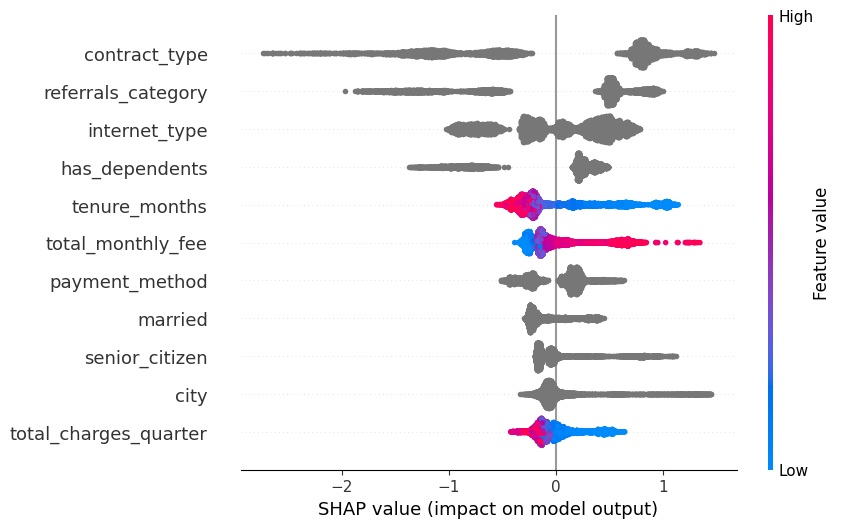

In [25]:
shap.plots.beeswarm(shap_values, max_display=len(cb_features))

In [28]:
churn_df['contract_type'].value_counts()

contract_type
Month-to-Month    3610
Two Year          1883
One Year          1550
Name: count, dtype: int64

In [29]:
churn_df['internet_type'].value_counts()

internet_type
Fiber Optic    3035
DSL            1652
Missing        1526
Cable           830
Name: count, dtype: int64

In [32]:
churn_df['tenure_months'].value_counts()

tenure_months
1     613
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: count, Length: 72, dtype: int64

In [34]:
churn_df['tenure_months'].mode()

0    1
Name: tenure_months, dtype: int64

In [36]:
churn_df['total_charges_quarter'].mode()

0    20.2
Name: total_charges_quarter, dtype: float64

In [37]:
churn_df['payment_method'].value_counts()

payment_method
Bank Withdrawal    3909
Credit Card        2749
Mailed Check        385
Name: count, dtype: int64

In [38]:
churn_df['married'].value_counts()

married
No     3641
Yes    3402
Name: count, dtype: int64

In [39]:
churn_df['has_dependents'].value_counts()

has_dependents
No     5416
Yes    1627
Name: count, dtype: int64

In [40]:
churn_df['senior_citizen'].value_counts()

senior_citizen
No     5901
Yes    1142
Name: count, dtype: int64

In [41]:
churn_df['city'].mode()

0    Los Angeles
Name: city, dtype: object

In [42]:
churn_df['city'].value_counts()

city
Los Angeles         293
San Diego           285
San Jose            112
Sacramento          108
San Francisco       104
                   ... 
Holtville             2
Johannesburg          2
Jacumba               2
Eldridge              2
South Lake Tahoe      2
Name: count, Length: 1106, dtype: int64

In [33]:
churn_df[cb_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   contract_type          7043 non-null   object 
 1   referrals_category     7043 non-null   object 
 2   has_dependents         7043 non-null   object 
 3   internet_type          7043 non-null   object 
 4   payment_method         7043 non-null   object 
 5   tenure_months          7043 non-null   int64  
 6   total_monthly_fee      7043 non-null   float64
 7   total_charges_quarter  7043 non-null   float64
 8   married                7043 non-null   object 
 9   senior_citizen         7043 non-null   object 
 10  city                   7043 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 605.4+ KB


In [35]:
churn_df[cb_features].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure_months,7043.0,32.386767,24.542061,1.00,9.00,29.00,55.00,72.00
total_monthly_fee,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges_quarter,7043.0,2280.381264,2266.220462,18.80,400.15,1394.55,3786.60,8684.80
